**Installations**

In [ ]:
  !pip install transformers

     |████████████████████████████████| 675kB 7.3MB/s 
     |████████████████████████████████| 3.8MB 39.2MB/s 
     |████████████████████████████████| 890kB 37.5MB/s 
     |████████████████████████████████| 1.1MB 32.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a74456e68df96ed83c1e028b08d7cd426e6393106002e266ec9cbf80cc25c720
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch

**Downloading CoLA data**

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3294139f80f46b5ab2ec1e23b0c4b4584317304f7cb36f27a0428bca6859c1ef
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


**extract and tokenize data**

In [ ]:
import csv
sentences=[]
labels=[]
with open("./cola_public/raw/in_domain_train.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line in tsvreader:
        sentences += [line[3]]
        labels += [int(line[1])]

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 


In [ ]:
# ici juste un tour pour voir quelle est la taille max . on visera un peu pls haut par sécurité.

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [ ]:
input_ids = []

for sent in sentences:
  encoded_dict = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict)
    

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([    0,  1541,   964,   351,    75,   907,    42,  1966,     6,   905,
         1937,     5,   220,    65,    52, 15393,     4,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


**prepare training and validation set**

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


**create model to be finetuned**

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

**prepare finetuning training**

In [ ]:
# see https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla K80


**train.**

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:56.
  Batch   120  of    241.    Elapsed: 0:01:24.
  Batch   160  of    241.    Elapsed: 0:01:51.
  Batch   200  of    241.    Elapsed: 0:02:19.
  Batch   240  of    241.    Elapsed: 0:02:47.

  Average training loss: 0.57
  Training epcoh took: 0:02:48

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.48
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:56.
  Batch   120  of    241.    Elapsed: 0:01:24.
  Batch   160  of    241.    Elapsed: 0:01:52.
  Batch   200  of    241.    Elapsed: 0:02:21.
  Batch   240  of    241.    Elapsed: 0:02:49.

  Average training loss: 0.41
  Training epcoh took: 0:02:49

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

# Gradient sanity check

In [ ]:
from transformers.modeling_utils import create_position_ids_from_input_ids
import matplotlib.pyplot as plt
import numpy as np

**experiments**

In [ ]:
 import torch.nn.functional as F

In [ ]:
x = input_ids[0].unsqueeze(0).to(device)
y=labels[0].unsqueeze(0).to(device)  
ind=2

In [ ]:
tokenizer.decode(x[0])

"<s> Our friends won't buy this analysis, let alone the next one we propose.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [ ]:
emb_matrix = model.roberta.embeddings.word_embeddings.weight
normed_emb_matrix=F.normalize(emb_matrix, p=2, dim=1) 

In [ ]:
def neighboors(embedd,numb):
  normed_emb_word=F.normalize(embedd, p=2, dim=0) 
  cosine_similarity = torch.matmul(normed_emb_word, torch.transpose(normed_emb_matrix,0,1))
  calc, closest_words = torch.topk(cosine_similarity,numb,dim=0)
  print(tokenizer.decode(closest_words))
  return closest_words

In [ ]:
def replace(x,ind,word):
  x[0][ind]=word
  return x

In [ ]:
model(replace(x,ind,int(closest_words[0])),labels=y)

(tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-2.4664,  2.1496]], device='cuda:0', grad_fn=<AddmmBackward>))

In [ ]:
model(replace(x,ind,73),labels=y)

(tensor(1.0773, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[ 0.1691, -0.4919]], device='cuda:0', grad_fn=<AddmmBackward>))

In [ ]:
tokenizer.decode(torch.Tensor([73]))

'/'

In [ ]:
def descent(x,y,ind):
  emb=predict1(x)
  att=PGDAttack(predict2, loss_fn=None, eps=0.3, nb_iter=100,
            eps_iter=0.005, rand_init=True, clip_min=-1., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False)
  rval, norm_memory, loss_memory =att.perturb(x,emb,ind,y)
  return rval

In [ ]:
embedd=descent(x,y,ind)[0][ind]
closest_words0=neighboors(embedd,10)

 friends friend buddies acquaintances friendships teammatesFriends girlfriends Friendsfriends


In [ ]:
embedd2=list(model.roberta.embeddings.children())[:1][0](x)[0][ind] #batch:0, word:ind
closest_words=neighboors(embedd2,10)

 friends friendFriends buddies Friendsfriends pals friendships girlfriends acquaintances


In [ ]:
closest_words

tensor([  964,  1441, 36042, 30489,  7837, 33601, 20633, 22942, 34333, 37069],
       device='cuda:0')

In [ ]:
cand=torch.empty((10,len(embedd2)))
for t in range(10):
  cand[t]=list(model.roberta.embeddings.children())[:1][0](closest_words[t].unsqueeze(0))
cand=cand.to(device)

In [ ]:
cand

tensor([[-0.0051, -0.2012, -0.0584,  ..., -0.0299,  0.0074,  0.1229],
        [ 0.0266, -0.1693, -0.0703,  ...,  0.0503, -0.0040,  0.1850],
        [ 0.1099, -0.0235, -0.0031,  ..., -0.1241, -0.0738,  0.1472],
        ...,
        [ 0.1863, -0.0026,  0.0776,  ..., -0.1752,  0.1869,  0.1562],
        [ 0.0842, -0.1774,  0.0298,  ...,  0.0288,  0.1118,  0.1221],
        [ 0.0991, -0.2500, -0.0022,  ..., -0.0839,  0.0688,  0.2494]],
       device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
emb=predict1(x)

In [ ]:
a, b, c = emb.size()
d=cand.size()[0]
embdelt = torch.zeros(d,a,b,c).to(device)
for jj in range(d):
  embdelt[jj][0][ind]=cand[jj]
embdelt=embdelt.permute(1,2,3,0)

In [ ]:
embdelt

In [ ]:
att=PGDAttack(predict2, loss_fn=None, eps=0.3, nb_iter=100,
            eps_iter=0.0001, rand_init=True, clip_min=-1., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False)

In [ ]:
rval, norm_memory, loss_memory =att.perturb_cand(x,emb,cand,embdelt,ind,y)  

RuntimeError: ignored

In [ ]:
torch.randn(4)

tensor([ 0.5097, -0.6720,  1.7055,  1.9970])

**gradient descent on one input WITHOUT advertorch**

In [ ]:
torch.rand((10)).size()

torch.Size([10])

In [ ]:
emb.size()

torch.Size([1, 64, 768])

epoch 0: norm of add is 1.655964 and loss is 1.174784e-02
epoch 1: norm of add is 1.656236 and loss is 1.175308e-02
epoch 2: norm of add is 1.656507 and loss is 1.175833e-02
epoch 3: norm of add is 1.656778 and loss is 1.176357e-02
epoch 4: norm of add is 1.657050 and loss is 1.176882e-02
epoch 5: norm of add is 1.657321 and loss is 1.177406e-02
epoch 6: norm of add is 1.657592 and loss is 1.177931e-02
epoch 7: norm of add is 1.657863 and loss is 1.178455e-02
epoch 8: norm of add is 1.658135 and loss is 1.178980e-02
epoch 9: norm of add is 1.658406 and loss is 1.179504e-02
epoch 10: norm of add is 1.658678 and loss is 1.180029e-02
epoch 11: norm of add is 1.658949 and loss is 1.180577e-02
epoch 12: norm of add is 1.659220 and loss is 1.181102e-02
epoch 13: norm of add is 1.659492 and loss is 1.181626e-02
epoch 14: norm of add is 1.659763 and loss is 1.182175e-02
epoch 15: norm of add is 1.660035 and loss is 1.182699e-02
epoch 16: norm of add is 1.660306 and loss is 1.183224e-02
epoch 1

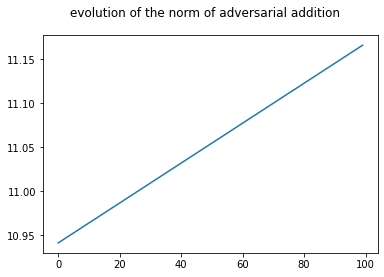

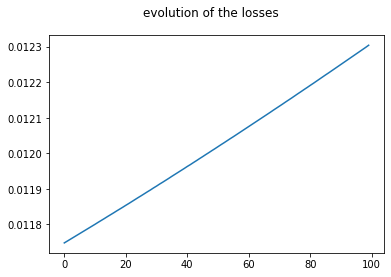

In [ ]:
#batch
x = input_ids[0].unsqueeze(0).to(device)
y = labels[0].unsqueeze(0).to(device)

#descent param
lr = 1e-4
n_epochs = 100

#contain results
norm_memory=np.zeros((n_epochs,))
loss_memory=np.zeros((n_epochs,))

add=torch.rand((10),requires_grad=True).to(device)
add.retain_grad()

emb=predict1(x)
for t in range(emb.size()[2]):
  emb[0][ind][t]=0

for epoch in range(n_epochs):
  out=predict2(x,emb+torch.matmul(embdelt,add))  

  criterion=torch.nn.CrossEntropyLoss()
  loss=criterion(out,y) 
  outgrad=loss.backward(retain_graph=True)

  print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
  norm_memory[epoch]=torch.norm(torch.matmul(embdelt,add),2)
  loss_memory[epoch]= loss

  with torch.no_grad():
        add += lr * torch.sign(add.grad)
      
  add.grad.zero_()

emb_final=emb+torch.matmul(embdelt,add)
  

print("descent")
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()


In [ ]:
#maximizing loss of linear combination of dictionary closest neighboors
advers=neighboors(emb_final[0][ind],10)

 friendsfriendsFriends acquaintances Friends girlfriends friendships friend buddies pals


In [ ]:
#dictionary closest neighboors
embedd2=list(model.roberta.embeddings.children())[:1][0](x)[0][ind] #batch:0, word:ind
closest_words=neighboors(embedd2,10)

 friends friendFriends buddies Friendsfriends pals friendships girlfriends acquaintances


In [ ]:
#maximizing loss in the neighborhood
embedd=descent(x,y,ind)[0][ind]
closest_words0=neighboors(embedd,10)

 friends friendFriends Friendsfriends classmates buddies colleagues allies cousins


In [ ]:
#find max of loss of each word of the combination 
maxi=0
amaxi=-1
for j in range(10):
  lss=float(model(replace(x,ind,closest_words[j]),labels=y)[0])
  if maxi<lss:
    maxi=lss
    amaxi=j
print(amaxi)
print(tokenizer.decode(closest_words[amaxi].unsqueeze(0)))
x = input_ids[0].unsqueeze(0).to(device)

2
Friends


In [ ]:
tokenizer.decode(x[0])

"<s> Our friends won't buy this analysis, let alone the next one we propose.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

**find adversarial function**

In [ ]:
iid=0 #sent number 0
ind = 2 #word number 2
neigh = 10 #length of candidates list

def find_adversarial(iid,ind,neigh):
  x = input_ids[iid].unsqueeze(0).to(device)
  print(tokenizer.decode(x[0]))
  print("\n")
  emb = predict1(x)
  y=labels[iid].unsqueeze(0).to(device)  

  emb_matrix = model.roberta.embeddings.word_embeddings.weight
  normed_emb_matrix=F.normalize(emb_matrix, p=2, dim=1) 

  #dictionary closest neighboors
  embedd2=list(model.roberta.embeddings.children())[:1][0](x)[0][ind] #batch:0, word:ind
  print("closest words of the dictionary to : "+tokenizer.decode(x[0][ind].unsqueeze(0))+" : ")
  closest_words=neighboors(embedd2,neigh)
  print("\n")

  #maximizing loss in the neighborhood
  embedd=descent(x,y,ind)[0][ind]
  print("max loss with PGD in the neighborhood of : "+tokenizer.decode(x[0][ind].unsqueeze(0))+" : ")
  closest_words0=neighboors(embedd,neigh)
  print("\n")

  cand=torch.empty((neigh,len(embedd2))) 
  for t in range(neigh):
    cand[t]=list(model.roberta.embeddings.children())[:1][0](closest_words[t].unsqueeze(0))
  cand=cand.to(device)

  a, b, c = emb.size()
  d=cand.size()[0]
  embdelt = torch.zeros(d,a,b,c).to(device)
  for jj in range(d):
    embdelt[jj][0][ind]=cand[jj]
  embdelt=embdelt.permute(1,2,3,0)

  #descent param
  lr = 1e-4
  n_epochs = 100

  add=torch.rand((neigh),requires_grad=True).to(device)
  add.retain_grad()

  for t in range(emb.size()[2]):
    emb[0][ind][t]=0

  for epoch in range(n_epochs):
    out=predict2(x,emb+torch.matmul(embdelt,add))  

    criterion=torch.nn.CrossEntropyLoss()
    loss=criterion(out,y) 
    outgrad=loss.backward(retain_graph=True)

    #print("epoch %s: norm of add is %f and loss is %e" %(epoch,torch.norm(add,2),loss))
    #norm_memory[epoch]=torch.norm(torch.matmul(embdelt,add),2)
    #loss_memory[epoch]= loss

    with torch.no_grad():
          add += lr * torch.sign(add.grad)
        
    add.grad.zero_()

  emb_final=emb+torch.matmul(embdelt,add)

  #maximizing loss of linear combination of dictionary closest neighboors
  print("max loss with PGD of linear combination of dict-neighboors of : "+tokenizer.decode(x[0][ind].unsqueeze(0))+" : ")
  advers=neighboors(emb_final[0][ind],10)
  print("\n")

  #find max of loss of each word of the combination 
  maxi=0
  amaxi=-1
  for j in range(10):
    lss=float(model(replace(x,ind,closest_words[j]),labels=y)[0])
    if maxi<lss:
      maxi=lss
      amaxi=j
  x = input_ids[0].unsqueeze(0).to(device)
  print("max loss between all neighboors of : "+tokenizer.decode(x[0][ind].unsqueeze(0))+" : ")
  print(tokenizer.decode(closest_words[amaxi].unsqueeze(0)))

**define parameters**

In [ ]:
iid=0 #sent number 0
ind = 2 #word number 2
neigh = 10 #length of candidates list

**find adversarial**

In [ ]:
find_adversarial(iid,ind,neigh)

<s> Our friends won't buy this analysis, let alone the next one we propose.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


closest words of the dictionary to :  friends : 
 friends friendFriends buddies Friendsfriends pals friendships girlfriends acquaintances


max loss with PGD in the neighborhood of :  friends : 
 friends friend FriendsFriendsfriends Friend buddiesfriend girlfriends acquaintances


max loss with PGD of linear combination of dict-neighboors of :  friends : 
 friendsFriends Friendsfriends buddies acquaintances friendships friend girlfriends pals


max loss between all neighboors of :  friends : 
Friends


In [ ]:
find_adversarial(iid,3,neigh)

<s> Our friends won't buy this analysis, let alone the next one we propose.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


closest words of the dictionary to :  won : 
 won win Won winning winswon Winning victory winners wouldn


max loss with PGD in the neighborhood of :  won : 
 won Won win winning wins wouldn didnwon earned doesn


max loss with PGD of linear combination of dict-neighboors of :  won : 
 won wins win winning Won winners Winning victorywon victories


max loss between all neighboors of :  won : 
 Won


**load advertorch**

In [ ]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 5.3MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=b4ac0dbf67ea38d61bd6dd551e496daabdf8f43ebdc2a784ed9cf8f6f9884bb0
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import torch
import torch.nn as nn

from advertorch.utils import clamp
from advertorch.utils import normalize_by_pnorm
from advertorch.utils import clamp_by_pnorm
from advertorch.utils import is_float_or_torch_tensor
from advertorch.utils import batch_multiply
from advertorch.utils import batch_clamp
from advertorch.utils import replicate_input
from advertorch.utils import batch_l1_proj

from advertorch.attacks.base import Attack
from advertorch.attacks.base import LabelMixin
from advertorch.attacks.utils import rand_init_delta

**define the two forward functions of our model**

In [ ]:

def predict1(x): #ex: x = input_ids[0].unsqueeze(0).to(device)

  emb=list(model.roberta.embeddings.children())[:1][0](x) #embedding of x

  return emb

def predict2(x,emb):

  #some model requirements for the calculation
  padding_idx=1
  input_shape = x.size()
  seq_length = input_shape[1]
  device = torch.device("cuda") 
  position_ids = create_position_ids_from_input_ids(x.to('cpu'), 1).to(device) 
  token_type_ids=torch.zeros(input_shape, dtype=torch.long, device=device)

  #model calculations:
  emb2=list(model.roberta.embeddings.children())[1:][0](position_ids)
  emb3=list(model.roberta.embeddings.children())[1:][1](token_type_ids)
  ess=list(model.roberta.embeddings.children())[1:][2](emb+emb2+emb3)  
  out_1st=list(model.roberta.embeddings.children())[1:][3](ess)  #result of the whole embedding layer of roberta

  #getting result of encoder layer of roberta
  out_2nd=model.roberta.encoder.layer[:12][0](out_1st)
  for i in range(1,12):
    out_2nd=model.roberta.encoder.layer[:12][i](out_2nd[0])

  #getting result of pooler layer of roberta
  out_3nd = model.roberta.pooler(out_2nd[0])
  out_4nd=(out_2nd[0], out_3nd,) + out_2nd[1:]
  out_fin=out_4nd[0]

  #getting result of classifier layer of roberta
  out=model.classifier(out_fin) #this is equivalent to model(x)

  return out

**defining advertorch functions**

In [ ]:
def sentlong(x): #real length of an input_id sentence 
  compteur = 0
  while compteur<len(x) and x[compteur]!=2:
    compteur+=1
  return compteur # compteur smallest index for which x[compteur]=2

def clean(x,emb): #zero all embeddings at indexes beyond the real sentence lenght
  size = emb.size()
  for b in range(size[0]): #batch_size
    sent_long=sentlong(x[b])
    for i in range(sent_long,size[1]): #real size of the sentence 
      emb[b,i,:]=torch.zeros(size[2]) #embedding size
  return emb


In [ ]:
class PGDAttack(Attack, LabelMixin):
    """
    The projected gradient descent attack (Madry et al, 2017).
    The attack performs nb_iter steps of size eps_iter, while always staying
    within eps from the initial point.
    Paper: https://arxiv.org/pdf/1706.06083.pdf
    :param predict: forward pass function.
    :param loss_fn: loss function.
    :param eps: maximum distortion.
    :param nb_iter: number of iterations.
    :param eps_iter: attack step size.
    :param rand_init: (optional bool) random initialization.
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :param ord: (optional) the order of maximum distortion (inf or 2).
    :param targeted: if the attack is targeted.
    """   

    def __init__(
            self, predict, loss_fn=None, eps=0.3, nb_iter=40,
            eps_iter=0.01, rand_init=True, clip_min=0., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False):
        """
        Create an instance of the PGDAttack.
        """
        super(PGDAttack, self).__init__(
            predict, loss_fn, clip_min, clip_max)
        self.eps = eps
        self.nb_iter = nb_iter
        self.eps_iter = eps_iter
        self.rand_init = rand_init
        self.ord = ord
        self.targeted = targeted  
        if self.loss_fn is None:
            self.loss_fn = nn.CrossEntropyLoss(reduction="sum") #or no reduction
        self.l1_sparsity = l1_sparsity
        assert is_float_or_torch_tensor(self.eps_iter)
        assert is_float_or_torch_tensor(self.eps)

    def perturb(self, x, emb, ind, y=None): #ind of word to be perturbed
        """
        Given examples (x, y), returns their adversarial counterparts with
        an attack length of eps.
        :param x: input tensor.
        :param y: label tensor.
                  - if None and self.targeted=False, compute y as predicted
                    labels.
                  - if self.targeted=True, then y must be the targeted labels.
        :return: tensor containing perturbed inputs.
        """
        emb, y = self._verify_and_process_inputs(emb, y) #???

        delta = torch.zeros_like(emb)
        delta = nn.Parameter(delta)
        if self.rand_init: 
            rand_init_delta( 
                delta, emb, self.ord, self.eps, self.clip_min, self.clip_max)
            delta.data = clamp(
                emb + delta.data, min=self.clip_min, max=self.clip_max) - emb  

        with torch.no_grad():
          for t in range(delta.size()[1]):
            if t!=ind:
              for k in range(delta.size()[2]):
                delta[0][t][k]=0

        #delta.data = clean(x,delta.data) #clean

 
        rval, norm_memory, loss_memory = perturb_iterative(
            x, emb, ind, y, self.predict, nb_iter=self.nb_iter,
            eps=self.eps, eps_iter=self.eps_iter,
            loss_fn=self.loss_fn, minimize=self.targeted,
            ord=self.ord, clip_min=self.clip_min,
            clip_max=self.clip_max, delta_init=delta,
            l1_sparsity=self.l1_sparsity,
        )

        return rval.data, norm_memory, loss_memory


    def perturb_cand(self, x, emb, cand, embdelt, ind, y=None): 
        """
        Given examples (x, y), returns their adversarial counterparts with
        an attack length of eps.
        :param x: input tensor.
        :param y: label tensor.
                  - if None and self.targeted=False, compute y as predicted
                    labels.
                  - if self.targeted=True, then y must be the targeted labels.
        :return: tensor containing perturbed inputs.
        """
        emb, cand, embdelt, y = self._verify_and_process_inputs(emb, cand, embdelt, y) #???

        
        delta = (1/cand.size()[0])*torch.ones([cand.size()[0]]).to(device)
        #delta = torch.rand(cand.size()[0]).to(device)
        #sm= torch.sum(delta)
        #delta = delta/sm 
        delta = nn.Parameter(delta)
        #if self.rand_init: 
        #    rand_init_delta( 
        #        delta, emb, self.ord, self.eps, self.clip_min, self.clip_max)
        #    delta.data = clamp(
        #        emb + delta.data, min=self.clip_min, max=self.clip_max) - emb

        #with torch.no_grad()

        #delta.data = clean(x,delta.data) #clean

 
        rval, norm_memory, loss_memory = perturb_iterative_cand(
            x, emb, embdelt, ind, y, self.predict, nb_iter=self.nb_iter,
            eps=self.eps, eps_iter=self.eps_iter,
            loss_fn=self.loss_fn, minimize=self.targeted,
            ord=self.ord, clip_min=self.clip_min,
            clip_max=self.clip_max, delta_init=delta,
            l1_sparsity=self.l1_sparsity,
        )

        return rval.data, norm_memory, loss_memory

    def perturb_cand2(self, x, emb, cmb, cand, embdelt, ind, y=None): #cmb = torch.ones(10) 10=cand.size()[0]
        """ 
        Given examples (x, y), returns their adversarial counterparts with
        an attack length of eps.
        :param x: input tensor.
        :param y: label tensor.
                  - if None and self.targeted=False, compute y as predicted
                    labels.
                  - if self.targeted=True, then y must be the targeted labels.
        :return: tensor containing perturbed inputs.
        """
        cmb, y = self._verify_and_process_inputs(cmb, y) #???

        delta = torch.zeros_like(cmb)
        delta = nn.Parameter(delta)
        if self.rand_init: 
            rand_init_delta( 
                delta, cmb, self.ord, self.eps, self.clip_min, self.clip_max)   #clip_min=0

        #with torch.no_grad()

        #delta.data = clean(x,delta.data) #clean

 
        rval, norm_memory, loss_memory = perturb_iterative_cand2(
            x, emb, embdelt, ind, y, self.predict, nb_iter=self.nb_iter,
            eps=self.eps, eps_iter=self.eps_iter,
            loss_fn=self.loss_fn, minimize=self.targeted,
            ord=self.ord, clip_min=self.clip_min,
            clip_max=self.clip_max, delta_init=delta,
            l1_sparsity=self.l1_sparsity,
        )

        return rval.data, norm_memory, loss_memory


In [ ]:
torch.ones([5])

tensor([1., 1., 1., 1., 1.])

In [ ]:
def perturb_iterative(xvar, embvar, indvar, yvar, predict, nb_iter, eps, eps_iter, loss_fn,
                      delta_init=None, minimize=False, ord=np.inf,
                      clip_min=0.0, clip_max=1.0,
                      l1_sparsity=None):
    """
    Iteratively maximize the loss over the input. It is a shared method for
    iterative attacks including IterativeGradientSign, LinfPGD, etc.
    :param xvar: input data.
    :param yvar: input labels.
    :param predict: forward pass function.
    :param nb_iter: number of iterations.
    :param eps: maximum distortion.
    :param eps_iter: attack step size.
    :param loss_fn: loss function.
    :param delta_init: (optional) tensor contains the random initialization.
    :param minimize: (optional bool) whether to minimize or maximize the loss.
    :param ord: (optional) the order of maximum distortion (inf or 2).
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :param l1_sparsity: sparsity value for L1 projection.
                  - if None, then perform regular L1 projection.
                  - if float value, then perform sparse L1 descent from
                    Algorithm 1 in https://arxiv.org/pdf/1904.13000v1.pdf
    :return: tensor containing the perturbed input.
    """
    #contain results
    norm_memory=np.zeros((nb_iter,))
    loss_memory=np.zeros((nb_iter,))
    #

    if delta_init is not None:
        delta = delta_init
    else:
        delta = torch.zeros_like(embvar)

    delta.requires_grad_()
    for ii in range(nb_iter):
        outputs = predict(xvar, embvar + delta)
        loss = loss_fn(outputs, yvar)
        if minimize:
            loss = -loss 

        loss.backward()
        if ord == np.inf: 
            grad_sign = delta.grad.data.sign()
            grad_sign = tozero(grad_sign,indvar)
            #print("before")
            #print(delta.data)
            #print(grad_sign)
            #clean(xvar,grad_sign)  #clean
            delta.data = delta.data + batch_multiply(eps_iter, grad_sign)
            #print(delta.data)
            delta.data = batch_clamp(eps, delta.data)
            #print(delta.data)
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
            with torch.no_grad():
              delta.data = tozero(delta.data,indvar)
            #print(delta.data)
            #print("after")
            #print(delta.data) 
                          

        elif ord == 2:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            grad = normalize_by_pnorm(grad)
            delta.data = delta.data + batch_multiply(eps_iter, grad)
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
            if eps is not None:
                delta.data = clamp_by_pnorm(delta.data, ord, eps)

        elif ord == 1:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            abs_grad = torch.abs(grad)

            batch_size = grad.size(0)
            view = abs_grad.view(batch_size, -1)
            view_size = view.size(1)
            if l1_sparsity is None:
                vals, idx = view.topk(1)
            else:
                vals, idx = view.topk(
                    int(np.round((1 - l1_sparsity) * view_size)))

            out = torch.zeros_like(view).scatter_(1, idx, vals)
            out = out.view_as(grad)
            grad = grad.sign() * (out > 0).float()
            grad = normalize_by_pnorm(grad, p=1)
            delta.data = delta.data + batch_multiply(eps_iter, grad)

            delta.data = batch_l1_proj(delta.data.cpu(), eps)
            if embvar.is_cuda:
                delta.data = delta.data.cuda()
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
        else:
            error = "Only ord = inf, ord = 1 and ord = 2 have been implemented"
            raise NotImplementedError(error)
        delta.grad.data.zero_()
        

        norm_memory[ii]=torch.norm(delta.data,2) 
        loss_memory[ii]= loss 
    
 
    emb_adv = clamp(embvar + delta, clip_min, clip_max)
    return emb_adv, norm_memory, loss_memory

In [ ]:
def perturb_iterative_cand(xvar, embvar, embdelt, indvar, yvar, predict, nb_iter, eps, eps_iter, loss_fn,
                      delta_init=None, minimize=False, ord=np.inf,
                      clip_min=0.0, clip_max=1.0,
                      l1_sparsity=None):
    """
    Iteratively maximize the loss over the input. It is a shared method for
    iterative attacks including IterativeGradientSign, LinfPGD, etc.
    :param xvar: input data.
    :param yvar: input labels.
    :param predict: forward pass function.
    :param nb_iter: number of iterations.
    :param eps: maximum distortion.
    :param eps_iter: attack step size.
    :param loss_fn: loss function.
    :param delta_init: (optional) tensor contains the random initialization.
    :param minimize: (optional bool) whether to minimize or maximize the loss.
    :param ord: (optional) the order of maximum distortion (inf or 2).
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :param l1_sparsity: sparsity value for L1 projection.
                  - if None, then perform regular L1 projection.
                  - if float value, then perform sparse L1 descent from
                    Algorithm 1 in https://arxiv.org/pdf/1904.13000v1.pdf
    :return: tensor containing the perturbed input.
    """
    #contain results
    norm_memory=np.zeros((nb_iter,))
    loss_memory=np.zeros((nb_iter,))
    
    if delta_init is not None:
        delta = delta_init

    #.detach_() 

    delta.requires_grad_()
    for ii in range(nb_iter): 
        outputs = predict(xvar, embvar + torch.matmul(embdelt,delta)) #delta[j] fois j-eme embedding qui est zerolike(embar) avec juste un embedding different 
        loss = loss_fn(outputs, yvar)
        if minimize:
            loss = -loss 

        loss.backward() 
        if ord == np.inf: 
            grad_sign = delta.grad.data.sign()
            
            delta.data = delta.data + batch_multiply(eps_iter, grad_sign)
            #delta.data = batch_clamp(eps, delta.data)
            #delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
            #                   ) - embvar.data
            

        elif ord == 2:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            grad = normalize_by_pnorm(grad)
            delta.data = delta.data + batch_multiply(eps_iter, grad)
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
            if eps is not None:
                delta.data = clamp_by_pnorm(delta.data, ord, eps)

        elif ord == 1:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            abs_grad = torch.abs(grad)

            batch_size = grad.size(0)
            view = abs_grad.view(batch_size, -1)
            view_size = view.size(1)
            if l1_sparsity is None:
                vals, idx = view.topk(1)
            else:
                vals, idx = view.topk(
                    int(np.round((1 - l1_sparsity) * view_size)))

            out = torch.zeros_like(view).scatter_(1, idx, vals)
            out = out.view_as(grad)
            grad = grad.sign() * (out > 0).float()
            grad = normalize_by_pnorm(grad, p=1)
            delta.data = delta.data + batch_multiply(eps_iter, grad)

            delta.data = batch_l1_proj(delta.data.cpu(), eps)
            if embvar.is_cuda:
                delta.data = delta.data.cuda()
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
        else:
            error = "Only ord = inf, ord = 1 and ord = 2 have been implemented"
            raise NotImplementedError(error)
        delta.grad.data.zero_()
        print('ok')
        norm_memory[ii]=torch.norm(delta.data,2) 
        loss_memory[ii]= loss 
    
 
    emb_adv = clamp(embvar + delta, clip_min, clip_max)
    return emb_adv, norm_memory, loss_memory

In [ ]:
def perturb_iterative_cand2(xvar, embvar, indvar, yvar, predict, nb_iter, eps, eps_iter, loss_fn,
                      delta_init=None, minimize=False, ord=np.inf,
                      clip_min=0.0, clip_max=1.0,
                      l1_sparsity=None):
    """
    Iteratively maximize the loss over the input. It is a shared method for
    iterative attacks including IterativeGradientSign, LinfPGD, etc.
    :param xvar: input data.
    :param yvar: input labels.
    :param predict: forward pass function.
    :param nb_iter: number of iterations.
    :param eps: maximum distortion.
    :param eps_iter: attack step size.
    :param loss_fn: loss function.
    :param delta_init: (optional) tensor contains the random initialization.
    :param minimize: (optional bool) whether to minimize or maximize the loss.
    :param ord: (optional) the order of maximum distortion (inf or 2).
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :param l1_sparsity: sparsity value for L1 projection.
                  - if None, then perform regular L1 projection.
                  - if float value, then perform sparse L1 descent from
                    Algorithm 1 in https://arxiv.org/pdf/1904.13000v1.pdf
    :return: tensor containing the perturbed input.
    """
    #contain results
    norm_memory=np.zeros((nb_iter,))
    loss_memory=np.zeros((nb_iter,))
    #

    if delta_init is not None:
        delta = delta_init
    else:
        delta = torch.zeros_like(embvar)

    delta.requires_grad_()
    for ii in range(nb_iter):
        outputs = predict(xvar, embvar + delta) #tenter matmul
        loss = loss_fn(outputs, yvar)
        if minimize:
            loss = -loss 

        loss.backward()
        if ord == np.inf: 
            grad_sign = delta.grad.data.sign()
            grad_sign = tozero(grad_sign,indvar)
            #print("before")
            #print(delta.data)
            #print(grad_sign)
            #clean(xvar,grad_sign)  #clean
            delta.data = delta.data + batch_multiply(eps_iter, grad_sign)
            #print(delta.data)
            delta.data = batch_clamp(eps, delta.data)
            #print(delta.data)
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
            with torch.no_grad():
              delta.data = tozero(delta.data,indvar)
            #print(delta.data)
            #print("after")
            #print(delta.data) 
                          

        elif ord == 2:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            grad = normalize_by_pnorm(grad)
            delta.data = delta.data + batch_multiply(eps_iter, grad)
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
            if eps is not None:
                delta.data = clamp_by_pnorm(delta.data, ord, eps)

        elif ord == 1:
            grad = delta.grad.data
            grad_sign = tozero(grad_sign,indvar)
            #clean(xvar,grad)  #clean
            abs_grad = torch.abs(grad)

            batch_size = grad.size(0)
            view = abs_grad.view(batch_size, -1)
            view_size = view.size(1)
            if l1_sparsity is None:
                vals, idx = view.topk(1)
            else:
                vals, idx = view.topk(
                    int(np.round((1 - l1_sparsity) * view_size)))

            out = torch.zeros_like(view).scatter_(1, idx, vals)
            out = out.view_as(grad)
            grad = grad.sign() * (out > 0).float()
            grad = normalize_by_pnorm(grad, p=1)
            delta.data = delta.data + batch_multiply(eps_iter, grad)

            delta.data = batch_l1_proj(delta.data.cpu(), eps)
            if embvar.is_cuda:
                delta.data = delta.data.cuda()
            delta.data = clamp(embvar.data + delta.data, clip_min, clip_max
                               ) - embvar.data
        else:
            error = "Only ord = inf, ord = 1 and ord = 2 have been implemented"
            raise NotImplementedError(error)
        delta.grad.data.zero_()
        

        norm_memory[ii]=torch.norm(delta.data,2) 
        loss_memory[ii]= loss 
    
 
    emb_adv = clamp(embvar + delta, clip_min, clip_max)
    return emb_adv, norm_memory, loss_memory

In [ ]:
def tozero(tens,ind):
  tens2=torch.zeros_like(tens)
  tens2[0][ind]=tens[0][ind]
  return tens2

In [ ]:
tozero(predict1(x),1) 

**gradient descent on one input WITH advertorch**

In [ ]:
x=input_ids[0].unsqueeze(0).to(device)
emb=predict1(x)
y=labels[0].unsqueeze(0).to(device)  
att=PGDAttack(predict2, loss_fn=None, eps=0.3, nb_iter=100,
            eps_iter=0.0001, rand_init=True, clip_min=0., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False)
rval, norm_memory, loss_memory =att.perturb(x,emb,y)

In [ ]:
plt.plot(norm_memory)
plt.suptitle('evolution of the norm of adversarial addition')
plt.axis()
plt.show()
plt.plot(loss_memory)
plt.suptitle('evolution of the losses')
plt.show()

**gradient descent on batch**

In [ ]:
input_ids_adv=input_ids.clone()

# Combine the training inputs into a TensorDataset.
dataset_adv = TensorDataset(input_ids_adv, labels)
 
adv_size = len(dataset_adv)  
 
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 10

# For validation the order doesn't matter, so we'll just read them sequentially.
dataloader_adv = DataLoader(
            dataset_adv, # The validation samples.
            sampler = SequentialSampler(dataset_adv), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
#batch

att=PGDAttack(predict2, loss_fn=None, eps=0.3, nb_iter=100,
            eps_iter=0.001, rand_init=True, clip_min=0., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False)



for incr, batch in enumerate(dataloader_adv):

  x= batch[0].to(device)
  emb=predict1(x)
  y=batch[1].to(device)  
  rval, norm_memory, loss_memory =att.perturb(x,emb,y)

  for a in range(n_epochs):
    plt.plot(norm_memory)
    plt.suptitle('evolution of the norm of adversarial addition')
    plt.axis()
    plt.show()
    plt.plot(loss_memory)
    plt.suptitle('evolution of the losses')
    plt.show()


# prepare adversarial dataset

In [ ]:
input_ids_adv=input_ids.clone()

# Combine the training inputs into a TensorDataset.
dataset_adv = TensorDataset(input_ids_adv, labels) 
 
# Calculate the number of samples to include in each set.
#adv_size = int(0.015 * len(dataset))
#adv_size2 = len(dataset_adv) - adv_size
adv_size = len(dataset)

shuffled_dataset = torch.utils.data.Subset(dataset_adv, torch.randperm(adv_size).tolist()) #shuffle
 
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 10

dataloader_adv = DataLoader(
            shuffled_dataset,  
            sampler = SequentialSampler(shuffled_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
#PREPARE ADVERSARIAL DATASET WITH GRADIENT DESCENT

add_data=[] #contains each perturbation for each batch

att=PGDAttack(predict2, loss_fn=None, eps=0.3, nb_iter=100,
            eps_iter=0.001, rand_init=True, clip_min=0., clip_max=1.,
            ord=np.inf, l1_sparsity=None, targeted=False)


incr=0
for batch in dataloader_adv:

  x= batch[0].to(device)
  emb=predict1(x)
  y=batch[1].to(device)  
  rval, norm_memory, loss_memory =att.perturb(x,emb,y)
  add_data+=[rval]

  incr+=1

  if len(add_data)%10==0:
    print(len(add_data))


In [ ]:
len(add_data)

**get adversarial inputs from adversarial embeddings (NN)**

In [ ]:
 import torch.nn.functional as F

In [ ]:
def adversarial(x,add_embed):

  #matrix of embeddings, and array of embeddings for which we want nearest neighboor
  emb_matrix = model.roberta.embeddings.word_embeddings.weight
  emb_array=list(model.roberta.embeddings.children())[:1][0](x) + add_embed

  normed_emb_matrix=F.normalize(emb_matrix, p=2, dim=1) 
  normed_emb_array=F.normalize(emb_array, p=2, dim=2) 

  #find nearest neighboor
  cosine_similarity = torch.matmul(normed_emb_array, torch.transpose(normed_emb_matrix,0,1))
  closest_words = torch.argmax(cosine_similarity,2)

  return closest_words

In [ ]:
#function to know if the adversarial input dataset does differ from the initial input dataset
def compare(x,closest_words): 
  diff=0
  for i in range(x.size()[0]):
    for j in range(x.size()[1]):
      if not(x[i,j]==closest_words[i,j]):
        diff+=1
  return 100*diff/(x.size()[0]*x.size()[1])

In [ ]:
# x: any input_id batch for which we want adversarial
#x= shuffled_dataset[:10][0].to(device)

comp = np.zeros([len(add_data)])

for incr, batch in enumerate(dataloader_adv):

  if incr>= len(add_data):
    break

  x= batch[0].to(device)
  closest_words = adversarial(x,add_data[incr])

  comp[incr]=compare(x,closest_words)

plt.plot(comp)
plt.suptitle('percentage of changed words for each batch')
plt.axis()
plt.show()

**loss of our model on adversarial dataset**

In [ ]:
#COMPARE VALIDATION OF MODEL ON INITIAL DATASET AND ADVERSARIAL DATASET
 
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Measure the total training time for the whole run.
total_t0 = time.time()


# ========================================
#               Validation
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.

print("")
print("Running Validation...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables  
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

total_eval_accuracy_adv = 0
total_eval_loss_adv = 0

incr=0
# Evaluate data for one epoch
for batch in dataloader_adv:

    if incr>=len(add_data):
      break
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)

    b_input_ids_adv = batch[0].to(device)
    b_labels_adv = batch[1].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                labels=b_labels)
        
        #(loss_adv, logits_adv) = model(adversarial(b_input_ids_adv,add_data[incr]), 
        #                        token_type_ids=None, 
        #                        labels=b_labels)

        #batch
        x = b_input_ids_adv
        emb = predict1(x)
        out = predict2(x,emb+add_data[incr])
        criterion=torch.nn.CrossEntropyLoss()
        loss_adv=criterion(out,b_labels_adv) 
        logits_adv = out

        
    # Accumulate the validation loss.
    total_eval_loss += loss.item()
    total_eval_loss_adv += loss_adv.item()

    # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    logits_adv = logits_adv.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

    total_eval_accuracy_adv += flat_accuracy(logits_adv, label_ids)

    incr+=1
    

# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy /len(add_data) # len(dataloader_adv)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
avg_val_accuracy_adv = total_eval_accuracy_adv /len(add_data) # len(dataloader_adv)
print("  Accuracy on adversarial: {0:.2f}".format(avg_val_accuracy_adv))

# Calculate the average loss over all of the batches.
avg_val_loss = total_eval_loss /len(add_data) # len(dataloader_adv)
avg_val_loss_adv = total_eval_loss_adv /len(add_data) # len(dataloader_adv)

# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)

print("  Validation took: {:}".format(validation_time))
print("  Validation Loss: {0:.2f}".format(avg_val_loss))
print(" Valid. Accur.: {:}".format(avg_val_accuracy))
print("  Validation Loss on adversarial: {0:.2f}".format(avg_val_loss_adv))
print(" Valid. Accur. on adversarial: {:}".format(avg_val_accuracy_adv))

print("")


**training our model on adversarial dataset**

In [ ]:
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset = torch.utils.data.Subset(shuffled_dataset, range(train_size))
val_dataset = torch.utils.data.Subset(shuffled_dataset, range(train_size,train_size+val_size))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 10

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset),  
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
#reload model

from transformers import RobertaForSequenceClassification, RobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model2 = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model2.cuda()


# see https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer2 = AdamW(model2.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler2 = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model2.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model2.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        if step<len(add_data):
          loss, logits = model2(adversarial(b_input_ids,add_data[step]), 
                              token_type_ids=None, 
                              labels=b_labels)
        else:
          loss, logits = model2(b_input_ids, 
                              token_type_ids=None, 
                              labels=b_labels)



        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer2.step()

        # Update the learning rate.
        scheduler2.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model2.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model2(b_input_ids, 
                                   token_type_ids=None, 
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
